In [1]:
import os
import numpy as np
import json
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import torch.optim as optim
import matplotlib.pyplot as plt
from collections import OrderedDict
from torchsummary import summary

%matplotlib inline

# check device
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print("We use " + DEVICE)
torch.cuda.empty_cache()

We use cuda


In [2]:
batch_size = 64
learning_rate = 1e-2
momentum = 0.7
weight_decay = 0.01
epochs = 100
patience = 7

In [3]:
transform = transforms.Compose([
                               transforms.Resize([256, 256]),
                               transforms.RandomCrop(224),
                               transforms.RandomHorizontalFlip(),
                               transforms.RandomVerticalFlip(),
                               transforms.RandomRotation(15),
                               transforms.ToTensor(),
                               transforms.Normalize(
                                   (0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
                               ])

train_db = datasets.CIFAR10('datasets/cifar10',
                            train=True,
                            download=True,
                            transform=transform,
                            )

test_db = datasets.CIFAR10('datasets/cifar10',
                           train=False,
                           download=True,
                           transform=transform,
                           )

print('train:', len(train_db), 'test:', len(test_db))

Files already downloaded and verified
Files already downloaded and verified
train: 50000 test: 10000


In [4]:
train_db, val_db = torch.utils.data.random_split(train_db, [40000, 10000])

print('train:', len(train_db), 'validation:', len(val_db))

train: 40000 validation: 10000


In [5]:
# number of workers
nw = min([os.cpu_count(), batch_size if batch_size > 1 else 0, 8])
print('Using {} dataloader workers every process'.format(nw))
train_loader = DataLoader(
    train_db,
    batch_size=batch_size,
    drop_last=True,
    shuffle=True,
    num_workers=nw,
)

val_loader = DataLoader(
    val_db,
    batch_size=batch_size,
    drop_last=True,
    shuffle=False,
    num_workers=nw,
)

test_loader = DataLoader(
    test_db,
    batch_size=batch_size,
    drop_last=True,
    shuffle=False,
    num_workers=nw,
)

Using 8 dataloader workers every process


In [6]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""

    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(
                f'EarlyStopping counter: {self.counter} out of {self.patience}\n')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(
                f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...\n')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [7]:
class BasicConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, relu=True, **kwargs):
        super(BasicConv2d, self).__init__()
        self.relu = relu
        if self.relu:
            self.feature = nn.Sequential(
                nn.Conv2d(in_channels=in_channels,
                          out_channels=out_channels, **kwargs),
                nn.BatchNorm2d(num_features=out_channels),
                nn.ReLU(inplace=True),
            )
        else:
            self.feature = nn.Sequential(
                nn.Conv2d(in_channels=in_channels,
                          out_channels=out_channels, **kwargs),
                nn.BatchNorm2d(num_features=out_channels),
            )

    def forward(self, x):
        out = self.feature(x)
        return out

In [8]:
class ShuffleBlock(nn.Module):
    def __init__(self, num_groups):
        super(ShuffleBlock, self).__init__()
        self.num_groups = num_groups

    def forward(self, x):
        out = self.shuffle_channel(x, self.num_groups)
        return out

    def shuffle_channel(self, x, num_groups):
        batch_size, num_channels, height, width = x.size()
        assert num_channels % num_groups == 0

        x = x.view(batch_size, num_groups, num_channels //
                   self.num_groups, height, width)
        x = x.permute(0, 2, 1, 3, 4)
        return x.contiguous().view(batch_size, num_channels, height, width)

In [9]:
class InvertedResidual(nn.Module):
    def __init__(self, in_channels, out_channels, stride):
        super(InvertedResidual, self).__init__()

        if stride not in [1, 2]:
            raise ValueError("illegal stride value.")
        self.stride = stride

        assert out_channels % 2 == 0
        branch_features = out_channels // 2
        # 当stride为1时，input_channel应该是branch_features的两倍
        # python中 '<<' 是位运算，可理解为计算×2的快速方法
        assert (self.stride != 1) or (in_channels == branch_features << 1)

        if self.stride == 2:
            self.branch1 = nn.Sequential(
                self.depthwise_conv(in_channels=in_channels, out_channels=in_channels,
                                    kernel_size=3, stride=self.stride, padding=1),
                BasicConv2d(in_channels=in_channels, out_channels=branch_features,
                            kernel_size=1, stride=1, padding=0, bias=False),
            )
        else:
            self.branch1 = nn.Sequential()

        self.branch2 = nn.Sequential(
            BasicConv2d(in_channels if self.stride > 1 else branch_features, branch_features, kernel_size=1,
                        stride=1, padding=0, bias=False),
            self.depthwise_conv(branch_features, branch_features,
                                kernel_size=3, stride=self.stride, padding=1),
            BasicConv2d(branch_features, branch_features,
                        kernel_size=1, stride=1, padding=0, bias=False),
        )
        self.ShuffleBlock = ShuffleBlock(num_groups=2)

    @staticmethod
    def depthwise_conv(in_channels, out_channels, kernel_size, stride=1, padding=0, bias=False):
        return BasicConv2d(in_channels=in_channels, out_channels=out_channels, relu=False, kernel_size=kernel_size,
                           stride=stride, padding=padding, bias=bias, groups=in_channels)

    def forward(self, x):
        if self.stride == 1:
            x1, x2 = x.chunk(2, dim=1)
            out = torch.cat((x1, self.branch2(x2)), dim=1)
        else:
            out = torch.cat((self.branch1(x), self.branch2(x)), dim=1)

        out = self.ShuffleBlock(out)

        return out

In [10]:
class ShuffleNetV2(nn.Module):
    def __init__(self, stages_repeats, stages_out_channels,
                 num_classes=10, inverted_residual=InvertedResidual):
        super(ShuffleNetV2, self).__init__()

        if len(stages_repeats) != 3:
            raise ValueError(
                "expected stages_repeats as list of 3 positive ints")
        if len(stages_out_channels) != 5:
            raise ValueError(
                "expected stages_out_channels as list of 5 positive ints")
        self._stage_out_channels = stages_out_channels

        # input RGB image
        in_channels = 3
        out_channels = self._stage_out_channels[0]

        self.conv1 = BasicConv2d(in_channels=in_channels, out_channels=out_channels,
                                 kernel_size=3, stride=2, padding=1, bias=False)

        in_channels = out_channels

        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        stage_names = ["stage{}".format(i) for i in [2, 3, 4]]
        for name, repeats, out_channels in zip(stage_names, stages_repeats,
                                                  self._stage_out_channels[1:]):
            seq = [inverted_residual(in_channels, out_channels, 2)]
            for i in range(repeats-1):
                seq.append(inverted_residual(
                    out_channels, out_channels, 1))
            setattr(self, name, nn.Sequential(*seq))
            in_channels = out_channels

        out_channels = self._stage_out_channels[-1]
        self.conv5 = BasicConv2d(in_channels=in_channels, out_channels=out_channels,
                                 kernel_size=1, stride=1, padding=0, bias=False)

        self.fc = nn.Linear(out_channels, num_classes)

    def _forward_impl(self, x):
        # See note [TorchScript super()]
        x = self.conv1(x)
        x = self.maxpool(x)
        x = self.stage2(x)
        x = self.stage3(x)
        x = self.stage4(x)
        x = self.conv5(x)
        x = x.mean([2, 3])  # global pool
        x = self.fc(x)
        return x

    def forward(self, x):
        return self._forward_impl(x)

In [11]:
def shufflenet_v2_x1_0(num_classes=10):
    """
    Constructs a ShuffleNetV2 with 1.0x output channels, as described in
    `"ShuffleNet V2: Practical Guidelines for Efficient CNN Architecture Design"
    <https://arxiv.org/abs/1807.11164>`.
    weight: https://download.pytorch.org/models/shufflenetv2_x1-5666bf0f80.pth

    :param num_classes:
    :return:
    """
    model = ShuffleNetV2(stages_repeats=[4, 8, 4],
                         stages_out_channels=[24, 116, 232, 464, 1024],
                         num_classes=num_classes)

    return model


def shufflenet_v2_x0_5(num_classes=10):
    """
    Constructs a ShuffleNetV2 with 0.5x output channels, as described in
    `"ShuffleNet V2: Practical Guidelines for Efficient CNN Architecture Design"
    <https://arxiv.org/abs/1807.11164>`.
    weight: https://download.pytorch.org/models/shufflenetv2_x0.5-f707e7126e.pth

    :param num_classes:
    :return:
    """
    model = ShuffleNetV2(stages_repeats=[4, 8, 4],
                         stages_out_channels=[24, 48, 96, 192, 1024],
                         num_classes=num_classes)

    return model

In [12]:
net = shufflenet_v2_x1_0().to(DEVICE)
criteon = nn.CrossEntropyLoss().to(DEVICE)
optimizer = optim.SGD(net.parameters(),
                      lr=learning_rate,
                      momentum=momentum,
                      weight_decay = weight_decay,
                      )

scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 'min', min_lr=1e-4, factor=0.1, patience=3)

In [13]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [14]:
summary(net, (3, 224, 224))
print(f'parameters_count: {count_parameters(net)}')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 24, 112, 112]             648
       BatchNorm2d-2         [-1, 24, 112, 112]              48
              ReLU-3         [-1, 24, 112, 112]               0
       BasicConv2d-4         [-1, 24, 112, 112]               0
         MaxPool2d-5           [-1, 24, 56, 56]               0
            Conv2d-6           [-1, 24, 28, 28]             216
       BatchNorm2d-7           [-1, 24, 28, 28]              48
       BasicConv2d-8           [-1, 24, 28, 28]               0
            Conv2d-9           [-1, 58, 28, 28]           1,392
      BatchNorm2d-10           [-1, 58, 28, 28]             116
             ReLU-11           [-1, 58, 28, 28]               0
      BasicConv2d-12           [-1, 58, 28, 28]               0
           Conv2d-13           [-1, 58, 56, 56]           1,392
      BatchNorm2d-14           [-1, 58,

In [15]:
def train(epoch):
    train_loss = 0
    train_acc = 0
    train_correct = 0
    net.train()
    for batch_idx, (data, label) in enumerate(train_loader):
        data, label = data.to(DEVICE), label.to(DEVICE)

        logits = net(data)
        loss = criteon(logits, label)
        train_loss += loss.item()

        pred = torch.argmax(logits, dim=1)
        train_correct += torch.eq(pred, label).float().sum().item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch + 1, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

    train_loss /= len(train_loader.dataset)
    train_acc = 1. * train_correct / len(train_loader.dataset)

    return train_loss, train_acc

In [16]:
def validate():
    val_loss = 0
    val_acc = 0
    val_correct = 0
    net.eval()
    with torch.no_grad():
        for data, label in val_loader:
            data, label = data.to(DEVICE), label.to(DEVICE)

            logits = net(data)
            val_loss += criteon(logits, label).item()

            pred = torch.argmax(logits, dim=1)
            val_correct += torch.eq(pred, label).float().sum().item()

    val_loss /= len(val_loader.dataset)
    val_acc = 1. * val_correct / len(val_loader.dataset)

    print('VAL set: Average loss: {:.6f}, Accuracy: {}/{} ({:.1f}%)'.format(
        val_loss, val_correct, len(val_loader.dataset), 100. * val_acc))

    return val_loss, val_acc

In [17]:
def test():
    test_loss = 0
    test_acc = 0
    test_correct = 0
    net.eval()
    with torch.no_grad():
        for data, label in test_loader:
            data, label = data.to(DEVICE), label.to(DEVICE)

            logits = net(data)
            test_loss += criteon(logits, label).item()

            pred = torch.argmax(logits, dim=1)
            test_correct += torch.eq(pred, label).float().sum().item()

    test_loss /= len(test_loader.dataset)
    test_acc = 1. * test_correct / len(test_loader.dataset)

    print('\nTest set: Average loss: {:.6f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, test_correct, len(test_loader.dataset), 100. * test_acc))

In [18]:
def plot_loss(train_losses, valid_losses):
    plt.style.use('seaborn')
    fig, ax = plt.subplots(figsize=(8, 4.5))
    
    # find position of lowest validation loss
    minpos = valid_losses.index(min(valid_losses))

    train_losses = np.array(train_losses)
    valid_losses = np.array(valid_losses)

    ax.plot(train_losses, color='blue', label='Training loss')
    ax.plot(valid_losses, color='red', label='Validation loss')
    ax.set(title="Loss over epochs",
           xlabel='Epoch',
           ylabel='Loss')
    
    plt.axvline(minpos, linestyle='--', color='r',
                label='Early Stopping Checkpoint')
    ax.legend()

    # change the plot style to default
    plt.style.use('default')

In [19]:
def plot_acc(train_accuracies, validate_accuracies):
    plt.style.use('seaborn')
    fig, ax = plt.subplots(figsize=(8, 4.5))

    # find position of lowest validation loss
    maxpos = validate_accuracies.index(max(validate_accuracies))

    train_accuracies = np.array(train_accuracies)
    validate_accuracies = np.array(validate_accuracies)

    ax.plot(train_accuracies, color='blue', label='Training accuracy')
    ax.plot(validate_accuracies, color='red', label='Validation accuracy')
    ax.set(title="Accuracy over epochs",
           xlabel='Epoch',
           ylabel='Accuracy')

    plt.axvline(maxpos, linestyle='--', color='r',
                label='Early Stopping Checkpoint')
    ax.legend()

    # change the plot style to default
    plt.style.use('default')

In [20]:
def main():
    train_losses = []
    validate_losses = []
    train_accuracies = []
    validate_accuracies = []
    early_stopping = EarlyStopping(patience=patience, verbose=True)
    for epoch in range(epochs):
        train_loss, train_accuracy = train(epoch)
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        validate_loss, validate_accuracy = validate()
        validate_losses.append(validate_loss)
        validate_accuracies.append(validate_accuracy)
        scheduler.step(validate_loss)
        early_stopping(val_loss=validate_loss, model=net)

        if early_stopping.early_stop:
            print("\nEarly stopping\n")
            break

    plot_loss(train_losses, validate_losses)
    plot_acc(train_accuracies, validate_accuracies)

    # load the last checkpoint with the best model
    net.load_state_dict(torch.load('checkpoint.pt'))

    test()

Train Epoch: 1 [0/40000 (0%)]	Loss: 2.354304
Train Epoch: 1 [6400/40000 (16%)]	Loss: 2.118957
Train Epoch: 1 [12800/40000 (32%)]	Loss: 1.998307
Train Epoch: 1 [19200/40000 (48%)]	Loss: 2.086609
Train Epoch: 1 [25600/40000 (64%)]	Loss: 1.923340
Train Epoch: 1 [32000/40000 (80%)]	Loss: 1.647481
Train Epoch: 1 [38400/40000 (96%)]	Loss: 1.729342
VAL set: Average loss: 0.027415, Accuracy: 3279.0/10000 (32.8%)
Validation loss decreased (inf --> 0.027415).  Saving model ...

Train Epoch: 2 [0/40000 (0%)]	Loss: 1.767212
Train Epoch: 2 [6400/40000 (16%)]	Loss: 1.779716
Train Epoch: 2 [12800/40000 (32%)]	Loss: 1.703165
Train Epoch: 2 [19200/40000 (48%)]	Loss: 1.765260
Train Epoch: 2 [25600/40000 (64%)]	Loss: 1.848523
Train Epoch: 2 [32000/40000 (80%)]	Loss: 1.958984
Train Epoch: 2 [38400/40000 (96%)]	Loss: 1.576235
VAL set: Average loss: 0.025638, Accuracy: 3746.0/10000 (37.5%)
Validation loss decreased (0.027415 --> 0.025638).  Saving model ...

Train Epoch: 3 [0/40000 (0%)]	Loss: 1.840547
Trai

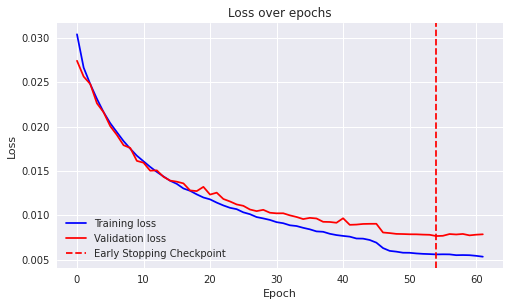

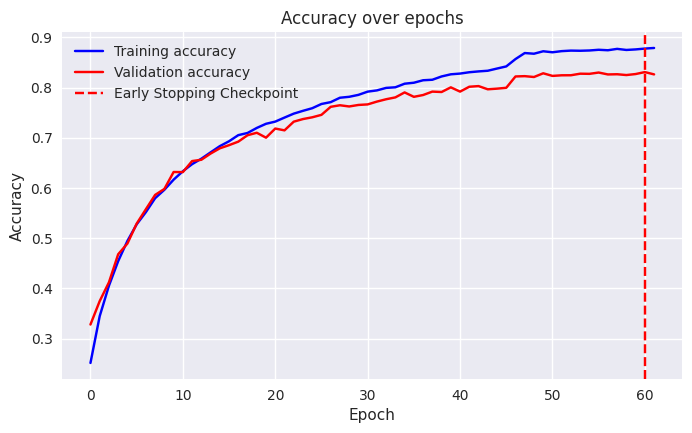

In [21]:
%%time
if __name__ == '__main__':
    main()

Text(0.5, 0.98, 'ShuffleNetV2 - predictions')

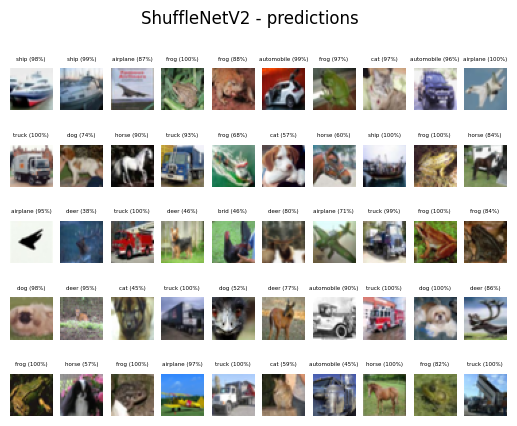

In [22]:
try:
    json_file = open('./class_indices.json', 'r')
    CIFAR_dict = json.load(json_file)
except Exception as e:
    print(e)
    exit(-1)

ROW_IMG = 10
N_ROWS = 5

fig = plt.figure()
for index in range(1, ROW_IMG * N_ROWS + 1):
    plt.subplot(N_ROWS, ROW_IMG, index)
    plt.axis('off')
    plt.imshow(test_db.data[index])

    with torch.no_grad():
        net.eval()
        logits = net(test_db[index][0].unsqueeze(0).to(DEVICE))
        probs = F.softmax(logits, dim=1)

    title = f'{CIFAR_dict[str(int(torch.argmax(probs)))]} ({torch.max(probs * 100):.0f}%)'

    plt.title(title, fontsize=4)

fig.suptitle('ShuffleNetV2 - predictions')

In [ ]:
"""
ShuffleNetV2
Mine(batch_size = 32):
After 20 Epoch: 67.0%
After 40 Epoch: 78.8%
After 59 Epoch: 79.4%
structure:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
================================================================
            Conv2d-1         [-1, 24, 112, 112]             648
       BatchNorm2d-2         [-1, 24, 112, 112]              48
              ReLU-3         [-1, 24, 112, 112]               0
       BasicConv2d-4         [-1, 24, 112, 112]               0
         MaxPool2d-5           [-1, 24, 56, 56]               0
            Conv2d-6           [-1, 24, 28, 28]             216
       BatchNorm2d-7           [-1, 24, 28, 28]              48
       BasicConv2d-8           [-1, 24, 28, 28]               0
            Conv2d-9           [-1, 58, 28, 28]           1,392
      BatchNorm2d-10           [-1, 58, 28, 28]             116
             ReLU-11           [-1, 58, 28, 28]               0
      BasicConv2d-12           [-1, 58, 28, 28]               0
           Conv2d-13           [-1, 58, 56, 56]           1,392
      BatchNorm2d-14           [-1, 58, 56, 56]             116
             ReLU-15           [-1, 58, 56, 56]               0
      BasicConv2d-16           [-1, 58, 56, 56]               0
           Conv2d-17           [-1, 58, 28, 28]             522
      BatchNorm2d-18           [-1, 58, 28, 28]             116
      BasicConv2d-19           [-1, 58, 28, 28]               0
           Conv2d-20           [-1, 58, 28, 28]           3,364
      BatchNorm2d-21           [-1, 58, 28, 28]             116
             ReLU-22           [-1, 58, 28, 28]               0
      BasicConv2d-23           [-1, 58, 28, 28]               0
     ShuffleBlock-24          [-1, 116, 28, 28]               0
 InvertedResidual-25          [-1, 116, 28, 28]               0
           Conv2d-26           [-1, 58, 28, 28]           3,364
      BatchNorm2d-27           [-1, 58, 28, 28]             116
             ReLU-28           [-1, 58, 28, 28]               0
      BasicConv2d-29           [-1, 58, 28, 28]               0
           Conv2d-30           [-1, 58, 28, 28]             522
      BatchNorm2d-31           [-1, 58, 28, 28]             116
      BasicConv2d-32           [-1, 58, 28, 28]               0
           Conv2d-33           [-1, 58, 28, 28]           3,364
      BatchNorm2d-34           [-1, 58, 28, 28]             116
             ReLU-35           [-1, 58, 28, 28]               0
      BasicConv2d-36           [-1, 58, 28, 28]               0
     ShuffleBlock-37          [-1, 116, 28, 28]               0
 InvertedResidual-38          [-1, 116, 28, 28]               0
           Conv2d-39           [-1, 58, 28, 28]           3,364
      BatchNorm2d-40           [-1, 58, 28, 28]             116
             ReLU-41           [-1, 58, 28, 28]               0
      BasicConv2d-42           [-1, 58, 28, 28]               0
           Conv2d-43           [-1, 58, 28, 28]             522
      BatchNorm2d-44           [-1, 58, 28, 28]             116
      BasicConv2d-45           [-1, 58, 28, 28]               0
           Conv2d-46           [-1, 58, 28, 28]           3,364
      BatchNorm2d-47           [-1, 58, 28, 28]             116
             ReLU-48           [-1, 58, 28, 28]               0
      BasicConv2d-49           [-1, 58, 28, 28]               0
     ShuffleBlock-50          [-1, 116, 28, 28]               0
 InvertedResidual-51          [-1, 116, 28, 28]               0
           Conv2d-52           [-1, 58, 28, 28]           3,364
      BatchNorm2d-53           [-1, 58, 28, 28]             116
             ReLU-54           [-1, 58, 28, 28]               0
      BasicConv2d-55           [-1, 58, 28, 28]               0
           Conv2d-56           [-1, 58, 28, 28]             522
      BatchNorm2d-57           [-1, 58, 28, 28]             116
      BasicConv2d-58           [-1, 58, 28, 28]               0
           Conv2d-59           [-1, 58, 28, 28]           3,364
      BatchNorm2d-60           [-1, 58, 28, 28]             116
             ReLU-61           [-1, 58, 28, 28]               0
      BasicConv2d-62           [-1, 58, 28, 28]               0
     ShuffleBlock-63          [-1, 116, 28, 28]               0
 InvertedResidual-64          [-1, 116, 28, 28]               0
           Conv2d-65          [-1, 116, 14, 14]           1,044
      BatchNorm2d-66          [-1, 116, 14, 14]             232
      BasicConv2d-67          [-1, 116, 14, 14]               0
           Conv2d-68          [-1, 116, 14, 14]          13,456
      BatchNorm2d-69          [-1, 116, 14, 14]             232
             ReLU-70          [-1, 116, 14, 14]               0
      BasicConv2d-71          [-1, 116, 14, 14]               0
           Conv2d-72          [-1, 116, 28, 28]          13,456
      BatchNorm2d-73          [-1, 116, 28, 28]             232
             ReLU-74          [-1, 116, 28, 28]               0
      BasicConv2d-75          [-1, 116, 28, 28]               0
           Conv2d-76          [-1, 116, 14, 14]           1,044
      BatchNorm2d-77          [-1, 116, 14, 14]             232
      BasicConv2d-78          [-1, 116, 14, 14]               0
           Conv2d-79          [-1, 116, 14, 14]          13,456
      BatchNorm2d-80          [-1, 116, 14, 14]             232
             ReLU-81          [-1, 116, 14, 14]               0
      BasicConv2d-82          [-1, 116, 14, 14]               0
     ShuffleBlock-83          [-1, 232, 14, 14]               0
 InvertedResidual-84          [-1, 232, 14, 14]               0
           Conv2d-85          [-1, 116, 14, 14]          13,456
      BatchNorm2d-86          [-1, 116, 14, 14]             232
             ReLU-87          [-1, 116, 14, 14]               0
      BasicConv2d-88          [-1, 116, 14, 14]               0
           Conv2d-89          [-1, 116, 14, 14]           1,044
      BatchNorm2d-90          [-1, 116, 14, 14]             232
      BasicConv2d-91          [-1, 116, 14, 14]               0
           Conv2d-92          [-1, 116, 14, 14]          13,456
      BatchNorm2d-93          [-1, 116, 14, 14]             232
             ReLU-94          [-1, 116, 14, 14]               0
      BasicConv2d-95          [-1, 116, 14, 14]               0
     ShuffleBlock-96          [-1, 232, 14, 14]               0
 InvertedResidual-97          [-1, 232, 14, 14]               0
           Conv2d-98          [-1, 116, 14, 14]          13,456
      BatchNorm2d-99          [-1, 116, 14, 14]             232
            ReLU-100          [-1, 116, 14, 14]               0
     BasicConv2d-101          [-1, 116, 14, 14]               0
          Conv2d-102          [-1, 116, 14, 14]           1,044
     BatchNorm2d-103          [-1, 116, 14, 14]             232
     BasicConv2d-104          [-1, 116, 14, 14]               0
          Conv2d-105          [-1, 116, 14, 14]          13,456
     BatchNorm2d-106          [-1, 116, 14, 14]             232
            ReLU-107          [-1, 116, 14, 14]               0
     BasicConv2d-108          [-1, 116, 14, 14]               0
    ShuffleBlock-109          [-1, 232, 14, 14]               0
InvertedResidual-110          [-1, 232, 14, 14]               0
          Conv2d-111          [-1, 116, 14, 14]          13,456
     BatchNorm2d-112          [-1, 116, 14, 14]             232
            ReLU-113          [-1, 116, 14, 14]               0
     BasicConv2d-114          [-1, 116, 14, 14]               0
          Conv2d-115          [-1, 116, 14, 14]           1,044
     BatchNorm2d-116          [-1, 116, 14, 14]             232
     BasicConv2d-117          [-1, 116, 14, 14]               0
          Conv2d-118          [-1, 116, 14, 14]          13,456
     BatchNorm2d-119          [-1, 116, 14, 14]             232
            ReLU-120          [-1, 116, 14, 14]               0
     BasicConv2d-121          [-1, 116, 14, 14]               0
    ShuffleBlock-122          [-1, 232, 14, 14]               0
InvertedResidual-123          [-1, 232, 14, 14]               0
          Conv2d-124          [-1, 116, 14, 14]          13,456
     BatchNorm2d-125          [-1, 116, 14, 14]             232
            ReLU-126          [-1, 116, 14, 14]               0
     BasicConv2d-127          [-1, 116, 14, 14]               0
          Conv2d-128          [-1, 116, 14, 14]           1,044
     BatchNorm2d-129          [-1, 116, 14, 14]             232
     BasicConv2d-130          [-1, 116, 14, 14]               0
          Conv2d-131          [-1, 116, 14, 14]          13,456
     BatchNorm2d-132          [-1, 116, 14, 14]             232
            ReLU-133          [-1, 116, 14, 14]               0
     BasicConv2d-134          [-1, 116, 14, 14]               0
    ShuffleBlock-135          [-1, 232, 14, 14]               0
InvertedResidual-136          [-1, 232, 14, 14]               0
          Conv2d-137          [-1, 116, 14, 14]          13,456
     BatchNorm2d-138          [-1, 116, 14, 14]             232
            ReLU-139          [-1, 116, 14, 14]               0
     BasicConv2d-140          [-1, 116, 14, 14]               0
          Conv2d-141          [-1, 116, 14, 14]           1,044
     BatchNorm2d-142          [-1, 116, 14, 14]             232
     BasicConv2d-143          [-1, 116, 14, 14]               0
          Conv2d-144          [-1, 116, 14, 14]          13,456
     BatchNorm2d-145          [-1, 116, 14, 14]             232
            ReLU-146          [-1, 116, 14, 14]               0
     BasicConv2d-147          [-1, 116, 14, 14]               0
    ShuffleBlock-148          [-1, 232, 14, 14]               0
InvertedResidual-149          [-1, 232, 14, 14]               0
          Conv2d-150          [-1, 116, 14, 14]          13,456
     BatchNorm2d-151          [-1, 116, 14, 14]             232
            ReLU-152          [-1, 116, 14, 14]               0
     BasicConv2d-153          [-1, 116, 14, 14]               0
          Conv2d-154          [-1, 116, 14, 14]           1,044
     BatchNorm2d-155          [-1, 116, 14, 14]             232
     BasicConv2d-156          [-1, 116, 14, 14]               0
          Conv2d-157          [-1, 116, 14, 14]          13,456
     BatchNorm2d-158          [-1, 116, 14, 14]             232
            ReLU-159          [-1, 116, 14, 14]               0
     BasicConv2d-160          [-1, 116, 14, 14]               0
    ShuffleBlock-161          [-1, 232, 14, 14]               0
InvertedResidual-162          [-1, 232, 14, 14]               0
          Conv2d-163          [-1, 116, 14, 14]          13,456
     BatchNorm2d-164          [-1, 116, 14, 14]             232
            ReLU-165          [-1, 116, 14, 14]               0
     BasicConv2d-166          [-1, 116, 14, 14]               0
          Conv2d-167          [-1, 116, 14, 14]           1,044
     BatchNorm2d-168          [-1, 116, 14, 14]             232
     BasicConv2d-169          [-1, 116, 14, 14]               0
          Conv2d-170          [-1, 116, 14, 14]          13,456
     BatchNorm2d-171          [-1, 116, 14, 14]             232
            ReLU-172          [-1, 116, 14, 14]               0
     BasicConv2d-173          [-1, 116, 14, 14]               0
    ShuffleBlock-174          [-1, 232, 14, 14]               0
InvertedResidual-175          [-1, 232, 14, 14]               0
          Conv2d-176            [-1, 232, 7, 7]           2,088
     BatchNorm2d-177            [-1, 232, 7, 7]             464
     BasicConv2d-178            [-1, 232, 7, 7]               0
          Conv2d-179            [-1, 232, 7, 7]          53,824
     BatchNorm2d-180            [-1, 232, 7, 7]             464
            ReLU-181            [-1, 232, 7, 7]               0
     BasicConv2d-182            [-1, 232, 7, 7]               0
          Conv2d-183          [-1, 232, 14, 14]          53,824
     BatchNorm2d-184          [-1, 232, 14, 14]             464
            ReLU-185          [-1, 232, 14, 14]               0
     BasicConv2d-186          [-1, 232, 14, 14]               0
          Conv2d-187            [-1, 232, 7, 7]           2,088
     BatchNorm2d-188            [-1, 232, 7, 7]             464
     BasicConv2d-189            [-1, 232, 7, 7]               0
          Conv2d-190            [-1, 232, 7, 7]          53,824
     BatchNorm2d-191            [-1, 232, 7, 7]             464
            ReLU-192            [-1, 232, 7, 7]               0
     BasicConv2d-193            [-1, 232, 7, 7]               0
    ShuffleBlock-194            [-1, 464, 7, 7]               0
InvertedResidual-195            [-1, 464, 7, 7]               0
          Conv2d-196            [-1, 232, 7, 7]          53,824
     BatchNorm2d-197            [-1, 232, 7, 7]             464
            ReLU-198            [-1, 232, 7, 7]               0
     BasicConv2d-199            [-1, 232, 7, 7]               0
          Conv2d-200            [-1, 232, 7, 7]           2,088
     BatchNorm2d-201            [-1, 232, 7, 7]             464
     BasicConv2d-202            [-1, 232, 7, 7]               0
          Conv2d-203            [-1, 232, 7, 7]          53,824
     BatchNorm2d-204            [-1, 232, 7, 7]             464
            ReLU-205            [-1, 232, 7, 7]               0
     BasicConv2d-206            [-1, 232, 7, 7]               0
    ShuffleBlock-207            [-1, 464, 7, 7]               0
InvertedResidual-208            [-1, 464, 7, 7]               0
          Conv2d-209            [-1, 232, 7, 7]          53,824
     BatchNorm2d-210            [-1, 232, 7, 7]             464
            ReLU-211            [-1, 232, 7, 7]               0
     BasicConv2d-212            [-1, 232, 7, 7]               0
          Conv2d-213            [-1, 232, 7, 7]           2,088
     BatchNorm2d-214            [-1, 232, 7, 7]             464
     BasicConv2d-215            [-1, 232, 7, 7]               0
          Conv2d-216            [-1, 232, 7, 7]          53,824
     BatchNorm2d-217            [-1, 232, 7, 7]             464
            ReLU-218            [-1, 232, 7, 7]               0
     BasicConv2d-219            [-1, 232, 7, 7]               0
    ShuffleBlock-220            [-1, 464, 7, 7]               0
InvertedResidual-221            [-1, 464, 7, 7]               0
          Conv2d-222            [-1, 232, 7, 7]          53,824
     BatchNorm2d-223            [-1, 232, 7, 7]             464
            ReLU-224            [-1, 232, 7, 7]               0
     BasicConv2d-225            [-1, 232, 7, 7]               0
          Conv2d-226            [-1, 232, 7, 7]           2,088
     BatchNorm2d-227            [-1, 232, 7, 7]             464
     BasicConv2d-228            [-1, 232, 7, 7]               0
          Conv2d-229            [-1, 232, 7, 7]          53,824
     BatchNorm2d-230            [-1, 232, 7, 7]             464
            ReLU-231            [-1, 232, 7, 7]               0
     BasicConv2d-232            [-1, 232, 7, 7]               0
    ShuffleBlock-233            [-1, 464, 7, 7]               0
InvertedResidual-234            [-1, 464, 7, 7]               0
          Conv2d-235           [-1, 1024, 7, 7]         475,136
     BatchNorm2d-236           [-1, 1024, 7, 7]           2,048
            ReLU-237           [-1, 1024, 7, 7]               0
     BasicConv2d-238           [-1, 1024, 7, 7]               0
          Linear-239                   [-1, 10]          10,250
================================================================
Total params: 1,263,854
Trainable params: 1,263,854
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.57
Forward/backward pass size (MB): 69.05
Params size (MB): 4.82
Estimated Total Size (MB): 74.45
----------------------------------------------------------------
parameters_count: 1263854
"""